In [1]:
import HomologyBasis as HB
from divisivegater.simplex_tree import SimplexTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations
import time

In [2]:
def random_ball(num_points, center, dimension=3, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Construct center point
    center_pt=[]
    for i in range(dimension):
        center_pt.append([center[i]]*num_points)
    # Return the list of random (direction & length) points.
    return ((radius * (random_directions * random_radii))+np.array(center_pt)).T

In [3]:
data=random_ball(num_points=25000,center=[0]*2,dimension=2,radius=1)

In [4]:
def persistence_check(pairs1,pairs2):
    for i in pairs1:
        for pair in pairs1[i]:
            if pair not in pairs2[i]:
                return False
    return True

In [5]:
max_dimension=1

HB_time=list()
ST_time=list()
iterations=list()

for n in range(50,2501,25):
    X=list([list(data[i]) for i in range(0,n)])
    maximal_faces=[list(sigma) for sigma in combinations(range(0,len(X)),max_dimension+1)]

    simplicial_complex = HB.simplicial_complex_from_maximal_faces(
        maximal_faces=maximal_faces, 
        max_dimension=max_dimension)

    filt_fct = HB.dictionary_filtration_function(
        simplicial_complex=simplicial_complex,
        filtration_value_function=HB.cech_filtration_function(X))

    start_HB=time.time()
    st_HB = HB.SimplexTree()
    for simplices in simplicial_complex:
        for face in simplices:
            st_HB.insert(face, filt_fct(face))

    persistent_homology_pairs = {index: pairs for index, pairs in enumerate(st_HB.persistent_homology(coeff_field=11))}
    total_HB=(time.time()-start_HB)
    
    start_ST=time.time()
    st = SimplexTree()
    for simplices in simplicial_complex:
        for face in simplices:
            st.insert(face, filt_fct(face))
            
    persistent_homology_pairs_st = {index: pairs for index, pairs in enumerate(st.persistent_homology(coeff_field=11))}
    total_ST=(time.time()-start_ST)

    if persistence_check(persistent_homology_pairs_st,persistent_homology_pairs)==False:
        print('Fail')
        break

    HB_time.append(total_HB)
    ST_time.append(total_ST)
    iterations.append(n)

In [6]:
proportion=np.array(HB_time)/np.array(ST_time)

C:\Users\pl3os\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


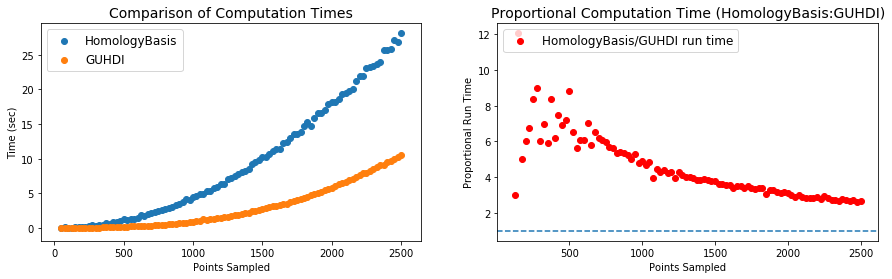

In [8]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
ax1.scatter(iterations,HB_time,label='HomologyBasis')
ax1.scatter(iterations,ST_time,label='GUHDI')
ax1.set_ylabel('Time (sec)')
ax1.set_xlabel('Points Sampled')
ax1.set_title('Comparison of Computation Times',fontsize=14)
ax1.legend(loc='upper left',fontsize=12)

ax2.scatter(iterations,proportion,color='red',label='HomologyBasis/GUHDI run time')
ax2.axhline(y=1,linestyle='--')
ax2.set_ylabel('Proportional Run Time')
ax2.set_xlabel('Points Sampled')
ax2.set_title('Proportional Computation Time (HomologyBasis:GUHDI)',fontsize=14)
ax2.legend(loc='upper left',fontsize=12)